function ClickConnect(){
console.log("Working");
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect,60000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pickle
from tqdm import tqdm

In [ ]:
version = 'v5'

### load and filter csv

In [ ]:
# load csv
train_path = "/content/drive/Shareddrives/AI_CUP_NLP/Batch_answers - train_data (no-blank).csv"
train_data = pd.read_csv(train_path, encoding = "utf-8", index_col='id').iloc[:,:5].applymap(lambda x: x.strip('"')).reset_index()

In [ ]:
train_data["length"] = train_data["q'"] + train_data["r'"]
train_data["length"] = train_data["length"].map(len)

In [ ]:
# target sample size
train_data.groupby(by=train_data.id).first().shape[0]

7987

In [ ]:
idx = train_data.groupby(by=train_data.id)['length'].transform(max) == train_data['length']
small_train_data = train_data[idx].set_index("id")

In [ ]:
small_train_data = small_train_data.groupby(by=small_train_data.index).first()

In [ ]:
small_train_data['q_length'] = small_train_data['q'].map(len)
small_train_data['r_length'] = small_train_data['r'].map(len)
small_train_data['s'] = small_train_data['s'].map(lambda x: 1 if x=="AGREE" else 0)

In [ ]:
# check sample size
small_train_data.shape[0]

7987

In [ ]:
# Save
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/small_train_data.pickle', 'wb') as f:
    pickle.dump(small_train_data, f)

In [ ]:
# Load
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/small_train_data.pickle', 'rb') as f:
    small_train_data = pickle.load(f)

### Remove bad words

In [ ]:
import re

In [ ]:
def regex_remove(text):
  text = re.sub("& #? ?[a-zA-Z\d]{2,8} ; ", '', text)
  text = re.sub("-- -- ", '', text)
  return text

In [ ]:
regex_data = small_train_data.copy()
regex_data['q'] = regex_data["q"].map(regex_remove)
regex_data['r'] = regex_data["r"].map(regex_remove)

In [ ]:
# Save
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/regex_data.pickle', 'wb') as f:
    pickle.dump(regex_data, f)

In [ ]:
# Load
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/regex_data.pickle', 'rb') as f:
    regex_data = pickle.load(f)

### testing

In [ ]:
# 評分用LCS
def LCS_Score(text1: str, text2: str) -> int:

    text1 = [i for i in word_tokenize(text1) if len(i)>1 or i not in punctuations]
    tokens = len(text1)
    text2 = [i for i in word_tokenize(text2) if len(i)>1 or i not in punctuations]

    if len(text2) > len(text1):
        text1, text2 = text2, text1
    lcs = [[0]*(len(text2)+1) for _ in range(2)]
    for i in range(1, len(text1)+1):
        for j in range(1, len(text2)+1):
            if text1[i-1]== text2[j-1]:
                lcs[i%2][j] = lcs[(i-1) % 2][j-1] +1
            else:
                lcs[i%2][j]= max(lcs[(i-1)%2][j], lcs[i % 2][j-1])
    lcs = lcs[len(text1)% 2][len(text2)]
    return  tokens, lcs / (len(text1) + len(text2) - lcs)

In [ ]:
evaluate_df = regex_data.copy()
q_tokens_list = []
q_score_list = []
r_tokens_list = []
r_score_list = []

for id in tqdm(evaluate_df.index):
  try:
    q_tokens, q_score = LCS_Score(evaluate_df['q'][id], evaluate_df["q'"][id])
  except:
    break
    q_tokens = q_score = 0
  try:
    r_tokens, r_score = LCS_Score(evaluate_df['r'][id], evaluate_df["r'"][id])
  except:
    r_tokens = r_score = 0
  q_score_list.append(q_score)
  r_score_list.append(r_score)
  q_tokens_list.append(q_tokens)
  r_tokens_list.append(r_tokens)

evaluate_df['q_tokens'] = q_tokens_list
evaluate_df['q_score'] = q_score_list
evaluate_df['r_tokens'] = r_tokens_list
evaluate_df['r_score'] = r_score_list

100%|██████████| 7987/7987 [00:31<00:00, 251.57it/s]


In [ ]:
mean_q_scores = []
mean_r_scores = []

for i in tqdm(range(5, 50)):
  q = evaluate_df[evaluate_df['q_tokens']<=i]["q_score"]
  mean_q_scores.append(sum(q)/len(q))

  r = evaluate_df[evaluate_df['r_tokens']<=i]["q_score"]
  mean_r_scores.append(sum(r)/len(r))

100%|██████████| 45/45 [00:00<00:00, 510.68it/s]


In [ ]:
import matplotlib.pyplot as plt

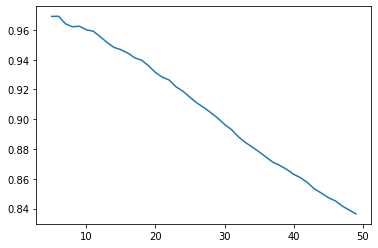

In [ ]:
plt.plot(range(5, 50), mean_q_scores)
plt.show()

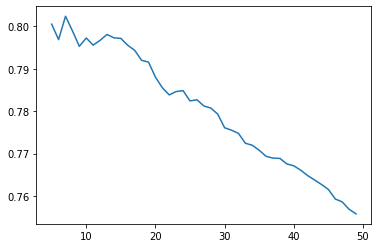

In [ ]:
plt.plot(range(5, 50), mean_r_scores)
plt.show()

### sentencize

In [ ]:
import spacy

In [ ]:
sentencizer = spacy.load('en_core_web_sm')

In [ ]:
def sentencize(sentence):
  sents = []
  for sent in sentencizer(sentence).sents:
    str_sent = str(sent)
    sents.extend(re.split("; ", str_sent))

  return sents

In [ ]:
texts = regex_data[['q', 'r', "q'", "r'"]]
texts = texts.applymap(sentencize)

In [ ]:
# Save
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/texts.pickle', 'wb') as f:
    pickle.dump(texts, f)

In [ ]:
# Load
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/texts.pickle', 'rb') as f:
    texts = pickle.load(f)

### extractive summary (shorten)

In [ ]:
# !pip install -q bert-extractive-summarizer
!pip install -q transformers

     |████████████████████████████████| 5.8 MB 14.6 MB/s 
     |████████████████████████████████| 182 kB 44.8 MB/s 
     |████████████████████████████████| 7.6 MB 52.3 MB/s 


In [ ]:
# from summarizer import Summarizer
from transformers import BertTokenizer
# bert_summarizer = Summarizer()
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def bert_token_length(text):
  tokens = tokenizer.encode_plus(text, add_special_tokens=True)
  return len(tokens['input_ids'])

# def spacy_sentencize_count(sentence):
#   return len([sent for sent in sentencizer(sentence).sents])

In [ ]:
# def bert_summarize(sentence):

#   token_length = bert_token_length(sentence)

#   if token_length > 400:
#     sentence_count = spacy_sentencize_count(sentence)
#     num_sentences = round(sentence_count * 400 / token_length)
    

#     bert_summary_1 = bert_summary = ''.join(bert_summarizer(sentence, num_sentences=num_sentences))
    

#     while num_sentences>1 and bert_token_length(bert_summary) > 450:
#       num_sentences -= 1
#       bert_summary = ''.join(bert_summarizer(sentence, num_sentences=num_sentences))
    
#     if bert_summary != "":
#       return bert_summary
#     elif bert_summary_1 != "":
#       return bert_summary_1

#   return sentence

In [ ]:
# summary = regex_data[['q', 'r']]
# summary = summary.applymap(bert_summarize)

In [ ]:
# res = summary['q'].map(bert_token_length).sort_values(ascending=False)

In [ ]:
# res[:10]

In [ ]:
# # Save
# with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/summary.pickle', 'wb') as f:
#     pickle.dump(summary, f)

In [ ]:
# Load
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/summary.pickle', 'rb') as f:
    summary = pickle.load(f)

### reformat

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
punctuations = '''!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~'''

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# revised LCS for labeling
def LCS(text1: str, text2: str) -> int:

    text1 = [i for i in word_tokenize(text1) if len(i)>1 or i not in punctuations]
    text2 = [i for i in word_tokenize(text2) if len(i)>1 or i not in punctuations]
    len_text2 = len(text2)
    if len_text2 == 0:
      return 0

    if len(text2) > len(text1):
        text1, text2 = text2, text1
    lcs = [[0]*(len(text2)+1) for _ in range(2)]
    for i in range(1, len(text1)+1):
        for j in range(1, len(text2)+1):
            if text1[i-1]== text2[j-1]:
                lcs[i%2][j] = lcs[(i-1) % 2][j-1] +1
            else:
                lcs[i%2][j]= max(lcs[(i-1)%2][j], lcs[i % 2][j-1])
    lcs = lcs[len(text1)% 2][len(text2)]
    return lcs/len_text2

In [ ]:
# revised labeling method

reformat_df = pd.DataFrame(columns=['id','sentence', 'is_q', 'label'])

for i in tqdm(small_train_data.index):
  q_sentence_count = len(texts["q"][i])
  r_sentence_count = len(texts["r"][i])
  if q_sentence_count == 0 or r_sentence_count == 0:
    continue
  
  ### Q ###
  temp_df = pd.DataFrame(columns=['id', 'sentence', 'is_q', 'label'])
  temp_df['sentence'] = texts['q'][i]
  temp_df['is_q'] = 1
  temp_df["id"] = i
  
  if q_sentence_count == 1:
    temp_df['label'] = 1
  else:
    score_dict = {}
    # max_score = 0
    # max_index = 0
    for j, sentence in enumerate(texts['q'][i]):
      score = LCS(sentence, small_train_data["q'"][i])
      score_dict[j] = score

      # if score >= 0.7:    # label good sentences out
      #   label_list.append(1)
      # else:
      #   label_list.append(0)

      # if score > max_score:  # at least label one sentence out
      #   max_score = score
      #   max_index = j

    cumsum = 0
    label_list = [0] * q_sentence_count
    for j, score in sorted(score_dict.items(), key=lambda item: item[1], reverse=True):
      if score==0:
        break
      cumsum += score
      label_list[j] = 1
      if cumsum >= 0.9:
        break

    # if sum(label_list) == 0:
    #   label_list[max_index] = 1

    temp_df['label'] = label_list

  reformat_df = pd.concat([reformat_df, temp_df], axis=0)

  ### R ###
  temp_df = pd.DataFrame(columns=['id', 'sentence', 'is_q', 'label'])
  temp_df['sentence'] = texts['r'][i]
  temp_df['is_q'] = 0
  temp_df["id"] = i

  if r_sentence_count == 1:
    temp_df['label'] = 1

  else:
    score_dict = {}
    # max_score = 0
    # max_index = 0
    for j, sentence in enumerate(texts['r'][i]):
      score = LCS(sentence, small_train_data["r'"][i])
      score_dict[j] = score

      # if score >= 0.7:    # label good sentences out
      #   label_list.append(1)
      # else:
      #   label_list.append(0)

      # if score > max_score:  # at least label one sentence out
      #   max_score = score
      #   max_index = j

    cumsum = 0
    label_list = [0] * r_sentence_count
    for j, score in sorted(score_dict.items(), key=lambda item: item[1], reverse=True):
      if score==0:
        break
      cumsum += score
      label_list[j] = 1
      if cumsum >= 0.9:
        break
   
    
    # if sum(label_list) == 0:
    #   label_list[max_index] = 1

    temp_df['label'] = label_list
  
  reformat_df = pd.concat([reformat_df, temp_df], axis=0)
  
reformat_df = reformat_df.set_index('id', drop=True)

100%|██████████| 7987/7987 [01:56<00:00, 68.48it/s]


In [ ]:
# Save
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/reformat_df.pickle', 'wb') as f:
    pickle.dump(reformat_df, f)

In [ ]:
# Load
with open(f'/content/drive/Shareddrives/AI_CUP_NLP/data_{version}/reformat_df.pickle', 'rb') as f:
    reformat_df = pickle.load(f)

### manual

In [ ]:
res = reformat_df.copy()
res['tokens'] = res['sentence'].map(bert_token_length)

In [ ]:
res_1 = pd.merge(res, small_train_data[["q'","r'"]], how="left", left_index=True, right_index=True).reset_index()

In [ ]:
res_2 = res_1[res_1['tokens']>100]

In [ ]:
res_2.to_csv('/content/drive/Shareddrives/AI_CUP_NLP/WIP/res_2.csv')

## Base Line

In [ ]:
import pandas as pd

In [ ]:
# load csv
train_path = "/content/drive/Shareddrives/AI_CUP_NLP/Batch_answers - test_data(no_label).csv"
train_data = pd.read_csv(train_path, encoding = "utf-8", index_col='id').iloc[:,:5].applymap(lambda x: x.strip('"')).reset_index()

In [ ]:
res_1 = train_data.copy()
res_1['tokens'] = res_1['sentence'].map(bert_token_length)

,id,q,r,s
0,6199,-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -...,"If so , why do we still have apes , and why ar...",DISAGREE
1,5807,There 's a lot of discussion there on that iss...,Of course . The makers of Expelled were within...,DISAGREE
2,8487,`` It 's not helping . The guns these people h...,"Oh , I would wager about like Mexico , about 8...",DISAGREE
3,1760,Shooting : 3 seriously injured in Auburn shoot...,Pickup strikes group of four youths | Houston ...,AGREE
4,6228,This is the argument concerning 'choice ' that...,I believe there is a point at which we ( socie...,DISAGREE
...,...,...,...,...
2011,9499,You are betraying your belief system .,Yep . ( I 'm assuming that by `` belief system...,AGREE
2012,4611,"You are in a loud minority , railing against t...",Being in the minority or in the majority is ir...,DISAGREE
2013,9328,You bet your XXX that 'd make me happy .,"Well , first , I probably would n't bet my XXX...",DISAGREE
2014,5225,you say `` f * * * the Constitution. ``,and gun nuts say f * * * the children when we ...,DISAGREE


In [ ]:
train_data["length"] = train_data["q'"] + train_data["r'"]
train_data["length"] = train_data["length"].map(len)
idx = train_data.groupby(by=train_data.id)['length'].transform(max) == train_data['length']
small_train_data = train_data[idx].reset_index(drop=True)
small_train_data = small_train_data.groupby(by=small_train_data.id).first().reset_index(drop=True)

In [ ]:
small_train_data['q_length'] = small_train_data['q'].map(len)
small_train_data['r_length'] = small_train_data['r'].map(len)

In [ ]:
# 評分用LCS
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
punctuations = '''!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~'''

def longestCommonSubsequence(text1: str, text2: str) -> int:

    text1 = [i for i in word_tokenize(text1) if len(i)>1 or i not in punctuations]
    text2 = [i for i in word_tokenize(text2) if len(i)>1 or i not in punctuations]

    if len(text2) > len(text1):
        text1, text2 = text2, text1
    lcs = [[0]*(len(text2)+1) for _ in range(2)]
    for i in range(1, len(text1)+1):
        for j in range(1, len(text2)+1):
            if text1[i-1]== text2[j-1]:
                lcs[i%2][j] = lcs[(i-1) % 2][j-1] +1
            else:
                lcs[i%2][j]= max(lcs[(i-1)%2][j], lcs[i % 2][j-1])
    lcs = lcs[len(text1)% 2][len(text2)]
    return lcs/(len(text1)+len(text2)-lcs)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from tqdm import tqdm

In [ ]:
q_score_list = []
r_score_list = []

for i in tqdm(small_train_data.index):
  try:
    q_score = longestCommonSubsequence(small_train_data['q'][i], small_train_data["q'"][i])
    r_score = longestCommonSubsequence(small_train_data['r'][i], small_train_data["r'"][i])
  except:
    q_score = -1
    r_score = -1

  
  q_score_list.append(q_score)
  r_score_list.append(r_score)

small_train_data['q_score'] = q_score_list
small_train_data['r_score'] = r_score_list
small_train_data['mean_score'] = (small_train_data['q_score'] + small_train_data['r_score'])/2

100%|██████████| 7987/7987 [00:39<00:00, 200.41it/s]


In [ ]:
sum(small_train_data['q_score']==-1), sum(small_train_data['r_score']==-1)

(0, 0)

In [ ]:
q_base_line = small_train_data['q_score'].sum() / small_train_data['q_score'].count()
r_base_line = small_train_data['r_score'].sum() / small_train_data['r_score'].count()
base_line = small_train_data['mean_score'].sum() / small_train_data['mean_score'].count()

q_base_line, r_base_line, base_line

(0.7111274291681386, 0.6609471793216652, 0.686037304244902)

## EDA

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def jitter(y):
  jittered_y = y + 0.005 * np.random.rand(len(y)) -0.005 * np.random.rand(len(y))
  return jittered_y

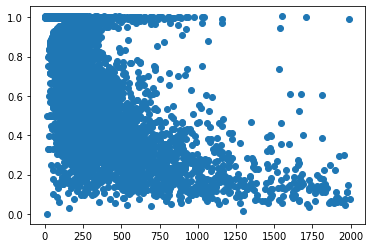

In [ ]:
q_data = small_train_data[small_train_data['q_length']<=2000]
plt.scatter(q_data['q_length'], jitter(q_data['q_score']))
plt.show()

In [ ]:
len(small_train_data) - len(q_data)

116

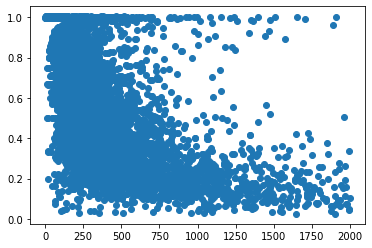

In [ ]:
r_data = small_train_data[small_train_data['r_length']<=2000]
plt.scatter(r_data['r_length'], jitter(r_data['r_score']))
plt.show()

In [ ]:
len(small_train_data) - len(r_data)

136

## find average max length for bert

In [ ]:
from transformers import BertTokenizer
BERT_MODEL_NAME = "bert-base-uncased" # we will use the BERT base model(the smaller one)
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
test_list = []
count = 0
for i in small_train_data.index:
  if small_train_data['q_length'][i] > 5000:
    test_list.append(i)
    count+=1

In [ ]:
def get_bert_length(sentence):
  input_ids = tokenizer(sentence, truncation=True)['input_ids']
  max_length = len(tokenizer.decode(input_ids, skip_special_tokens=True))
  return max_length

In [ ]:
length_list = [get_bert_length(small_train_data['q'][i]) for i in test_list]

In [ ]:
len(length_list)

27

In [ ]:
list(np.quantile(length_list, q = np.array([0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1])))

[2078.0, 2119.86, 2245.6, 2295.0, 2430.0, 2482.0, 2515.6, 2624.44, 2652.0]

In [ ]:
r_test_list = []
for i in small_train_data.index:
  if small_train_data['r_length'][i] > 5000:
    r_test_list.append(i)

In [ ]:
r_length_list = [get_bert_length(small_train_data['r'][i]) for i in r_test_list]

In [ ]:
len(r_length_list)

25

In [ ]:
list(np.quantile(r_length_list, q = np.array([0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 1])))

[1796.0, 1831.28, 2120.0, 2257.0, 2320.0, 2349.0, 2476.0, 2491.84, 2494.0]

In [ ]:
!pip install -q bert-extractive-summarizer
!pip install -q transformers
!pip install -q spacy
!pip install -q gensim==3.8.0
!pip install -q pysummarization

     |████████████████████████████████| 5.5 MB 7.7 MB/s 
     |████████████████████████████████| 182 kB 64.6 MB/s 
     |████████████████████████████████| 7.6 MB 36.4 MB/s 
     |████████████████████████████████| 24.2 MB 1.3 MB/s 
     |████████████████████████████████| 64 kB 1.5 MB/s 


In [ ]:
from summarizer import Summarizer,TransformerSummarizer
bert_model = Summarizer()
def bert_summarize(sentence, length):
  if length<=2000:
    return sentence
  bert_summary = ''.join(bert_model(sentence, max_length=2000))
  return bert_summary

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
small_train_data['q_summary'] = ''
small_train_data['r_summary'] = ''

for i in tqdm(small_train_data.index):
  small_train_data['q_summary'][i] = bert_summarize(small_train_data['q'][i], small_train_data['q_length'][i])
  small_train_data['r_summary'][i] = bert_summarize(small_train_data['r'][i], small_train_data['r_length'][i])

100%|██████████| 7987/7987 [1:02:14<00:00,  2.14it/s]


In [ ]:
import pickle

In [ ]:
# Save
with open('/content/drive/Shareddrives/AI_CUP_NLP/summary.pickle', 'wb') as f:
    pickle.dump(small_train_data, f)

In [ ]:
# Load
# with open('/content/drive/Shareddrives/AI_CUP_NLP/summary.pickle', 'rb') as f:
#     summary = pickle.load(f)